## 🤩 Initialization


In [ ]:
# g drive connect
from google.colab import drive
drive.mount("/gdrive")
%cd /gdrive/My Drive/HW2

Mounted at /gdrive
/gdrive/My Drive/HW2


In [ ]:
# Imports
import os
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Enable inline plotting in Jupyter Notebooks
%matplotlib inline


# TensorFlow Keras layers and model building
from tensorflow.keras.layers import Layer, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import register_keras_serializable

from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, Model


In [ ]:
# random seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# dataset
data = np.load("cleaned_dataset.npz")
# separate training+val (labelled) and test (unlabelled)
training_val_test_set = data["training_set"] # training set + validation set
X_test_kaggle = data["test_set"] # kaggle test set
# divide images and labels in training+val
X_train_val_test = training_val_test_set[:, 0]
y_train_val_test = training_val_test_set[:, 1]
# normalize all images. both training+val (labelled) and test (unlabelled)
X_train_val_test = X_train_val_test[..., np.newaxis] / 255.0
X_test_kaggle = X_test_kaggle[..., np.newaxis] / 255.0
# compute problem parameters
input_shape = X_train_val_test.shape[1:]
num_classes = len(np.unique(y_train_val_test))
print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")
# divide training and val
X_train_val, X_test, y_train_val, y_test = train_test_split(X_train_val_test, y_train_val_test, random_state=seed, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1)
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Validation X shape: {X_val.shape}")
print(f"Validation y shape: {y_val.shape}")

Input shape: (64, 128, 1)
Number of classes: 5
Training X shape: (2028, 64, 128, 1)
Training y shape: (2028, 64, 128)
Validation X shape: (226, 64, 128, 1)
Validation y shape: (226, 64, 128)


In [ ]:
# Class Weights computation
flattened_labels = y_train.flatten()
class_weights = compute_class_weight('balanced', classes=np.unique(flattened_labels), y=flattened_labels)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

def create_sample_weights(y, class_weight_dict):
    # Crea una mappa di pesi per ciascun pixel
    sample_weights = np.zeros_like(y, dtype=np.float32)
    for class_id, weight in class_weight_dict.items():
        sample_weights[y == class_id] = weight
    return sample_weights

sample_weights_train = np.array([create_sample_weights(y, class_weight_dict) for y in y_train])

Class weights: {0: 0.806672706985308, 1: 0.600511722870817, 2: 0.8324216719356785, 3: 1.1271868561846474, 4: 151.17499431275309}


## 🛠️ Train and Save the Model

In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 300

In [ ]:
category_map = {
        0: 0,  # background
        1: 1,  # soil
        2: 2,  # bedrock
        3: 3,  # sand
        4: 4,  # big rock
}


# Calculate the correct number of classes after mapping
NUM_CLASSES = len(set(category_map.values()))
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 5


In [ ]:
print(X_train.min(),X_train.max())

0.011764705882352941 0.996078431372549


In [ ]:
@register_keras_serializable()
class AdaptiveThresholdingLayer(tf.keras.layers.Layer):
    def __init__(self, block_size=11, c=2, print_flag=False, **kwargs):
        """
        Adaptive Thresholding Layer
        Args:
            block_size: Size of the neighborhood used to calculate the local threshold (must be odd).
            c: Constant subtracted from the local mean.
            print_flag: Flag to print input shapes for debugging.
        """
        super(AdaptiveThresholdingLayer, self).__init__(**kwargs)
        self.block_size = block_size
        self.c = c
        self.print_flag = print_flag  # Assegna il valore di print_flag

    def call(self, inputs):
        if self.print_flag:
            print("Input shape before:", inputs.shape)
            # Assicurati che l'input abbia 4 dimensioni: [batch_size, height, width, channels]
            inputs = tf.squeeze(inputs, axis=-1)  # Rimuove la dimensione extra
            print("Input shape after:", inputs.shape)


        # Thresholding adattivo: immagine binaria basata > C
        thresholded = tf.where(inputs >  self.c, tf.ones_like(inputs), tf.zeros_like(inputs))

        if self.print_flag:
            print("Thresholded output shape:", thresholded.shape)

        return thresholded

    def get_config(self):
        config = super().get_config()
        config.update({"block_size": self.block_size, "c": self.c, "print_flag": self.print_flag})
        return config

In [ ]:
# Edge detection layer con filtro Prewitt
@register_keras_serializable()
class EdgeDetectionLayer(tf.keras.layers.Layer):
    def __init__(self, print_flag=False, **kwargs):
        super(EdgeDetectionLayer, self).__init__(**kwargs)
        self.print_flag = print_flag  # Assegna print_flag come attributo della classe

    def call(self, inputs):
        if self.print_flag:
            print("Input shape before:", inputs.shape)
            # Assicurati che l'input abbia 4 dimensioni: [batch_size, height, width, channels]
            inputs = tf.squeeze(inputs, axis=-1)  # Rimuove la dimensione extra
            print("Input shape after:", inputs.shape)

        # Filtro Prewitt per il rilevamento dei bordi (direzione orizzontale e verticale)
        prewitt_kernel_x = tf.constant([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=tf.float32)  # Filtro orizzontale
        prewitt_kernel_y = tf.constant([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], dtype=tf.float32)  # Filtro verticale

        prewitt_kernel_x = tf.reshape(prewitt_kernel_x, [3, 3, 1, 1])  # Riformatta per convoluzione
        prewitt_kernel_y = tf.reshape(prewitt_kernel_y, [3, 3, 1, 1])  # Riformatta per convoluzione

        # Applicazione del filtro Prewitt in entrambe le direzioni (x e y)
        edges_x = tf.nn.conv2d(inputs, prewitt_kernel_x, strides=[1, 1, 1, 1], padding="SAME")
        edges_y = tf.nn.conv2d(inputs, prewitt_kernel_y, strides=[1, 1, 1, 1], padding="SAME")

        # Calcola la magnitudine del gradiente (combinazione delle due direzioni)
        edges = tf.sqrt(tf.square(edges_x) + tf.square(edges_y))

        return edges

    def get_config(self):
        config = super().get_config()
        config.update({"print_flag": self.print_flag})  # Includi print_flag nella configurazione
        return config

In [ ]:
# Laplacian Layer
@register_keras_serializable()
class LaplacianLayer(tf.keras.layers.Layer):
    def __init__(self,print_flag=False, **kwargs):
        super(LaplacianLayer, self).__init__(**kwargs)
        self.print_flag = print_flag

    def call(self, inputs):
        if self.print_flag:
            print("Input shape before:", inputs.shape)
            # Assicurati che l'input abbia 4 dimensioni: [batch_size, height, width, channels]
            inputs = tf.squeeze(inputs, axis=-1)  # Rimuove la dimensione extra
            print("Input shape after:", inputs.shape)


        # Calcola il kernel laplaciano
        laplacian_kernel = tf.constant([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=tf.float32)
        laplacian_kernel = laplacian_kernel[:, :, tf.newaxis, tf.newaxis]  # (3, 3, 1, 1)
        laplacian = tf.nn.conv2d(inputs, laplacian_kernel, strides=1, padding="SAME")
        return laplacian

    def get_config(self):
        return super().get_config()

In [ ]:
# Wavelet layer
@register_keras_serializable()
class WaveletTransformLayer(Layer):
    def __init__(self, wavelet='haar', normalize=True, log_scale=True, print_flag=False, **kwargs):
        """
        Custom Layer for Wavelet Transform.

        Args:
            wavelet: The type of wavelet to use. (e.g., 'haar', 'db1', etc.)
            normalize: Flag to normalize the wavelet transform result.
            log_scale: Flag to apply log scale for better visualization.
            print_flag: Flag to print input shapes for debugging.
        """
        super(WaveletTransformLayer, self).__init__(**kwargs)
        self.wavelet = wavelet
        self.normalize = normalize
        self.log_scale = log_scale
        self.print_flag = print_flag

    def wavelet_transform_2d(self, tensor):
        """
        Perform 2D wavelet transform using the specified wavelet filter.

        Args:
            tensor: Input 2D tensor (batch, height, width, channels).

        Returns:
            Wavelet transform coefficients.
        """
        # Perform a 2D discrete wavelet transform (DWT) using TensorFlow (can use pywt for more wavelet options)
        # Here we'll use Haar wavelet for simplicity (this part can be expanded).

        # Example with Haar wavelet (use `tf.signal` or external library for other wavelets)
        if self.wavelet == 'haar':
            # Haar wavelet transform: split image into low and high frequency components
            lowpass, highpass = tf.signal.dct(tensor, type=2, norm='ortho'), tensor  # Simplified for Haar-like behavior
        else:
            # You can add support for other wavelets here, using `pywt` or other libraries.
            raise NotImplementedError("Only Haar wavelet is implemented in this example.")

        return lowpass, highpass

    def call(self, inputs):
        if self.print_flag:
            print("Input shape before:", inputs.shape)

        # Ensure inputs are 4D [batch, height, width, channels]
        if len(inputs.shape) == 4 and inputs.shape[-1] != 1:
            raise ValueError("Input should have a single channel (grayscale).")

        # Remove the channel dimension if present
        inputs = tf.squeeze(inputs, axis=-1)
        if self.print_flag:
            print("Input shape after squeezing:", inputs.shape)

        # Step 1: Apply Wavelet Transform (e.g., Haar)
        lowpass, highpass = self.wavelet_transform_2d(tf.cast(inputs, tf.float32))
        if self.print_flag:
            print("Shape after wavelet transform:", lowpass.shape, highpass.shape)

        # Step 2: Combine or choose parts of the wavelet coefficients (here we take lowpass for simplicity)
        wavelet_transformed = lowpass  # Can choose to return both lowpass and highpass, or just one

        # Step 3: Normalize the result
        if self.normalize:
            wavelet_transformed = tf.image.per_image_standardization(wavelet_transformed)
            wavelet_transformed = tf.clip_by_value(wavelet_transformed, 0, 1)

        # Step 4: Apply logarithmic scaling for better visualization
        if self.log_scale:
            wavelet_transformed = tf.math.log(1 + tf.abs(wavelet_transformed))
            if self.print_flag:
                print("Log-scaled wavelet transform output shape:", wavelet_transformed.shape)

        # Restore shape to 4D [batch, height, width, channels]
        wavelet_transformed = tf.expand_dims(wavelet_transformed, axis=-1)
        if self.print_flag:
            print("Output shape restored to 4D:", wavelet_transformed.shape)

        return wavelet_transformed

    def get_config(self):
        """
        Returns the configuration of the layer for serialization.
        """
        config = super().get_config()
        config.update({
            "wavelet": self.wavelet,
            "normalize": self.normalize,
            "log_scale": self.log_scale,
            "print_flag": self.print_flag,
        })
        return config

Input shape before: (1, 64, 128, 1, 1)
Input shape after: (1, 64, 128, 1)
Input shape before: (1, 64, 128, 1, 1)
Input shape after: (1, 64, 128, 1)
Input shape before: (1, 64, 128, 1, 1)
Input shape after squeezing: (1, 64, 128, 1)
Shape after wavelet transform: (1, 64, 128, 1) (1, 64, 128, 1)
Log-scaled wavelet transform output shape: (1, 64, 128, 1)
Output shape restored to 4D: (1, 64, 128, 1, 1)
Input shape before: (1, 64, 128, 1, 1)
Input shape after: (1, 64, 128, 1)
Thresholded output shape: (1, 64, 128, 1)
Input shape before: (1, 64, 128, 1, 1)
Input shape after: (1, 64, 128, 1)
Input shape before: (1, 64, 128, 1, 1)
Input shape after: (1, 64, 128, 1)
Input shape before: (1, 64, 128, 1, 1)
Input shape after squeezing: (1, 64, 128, 1)
Shape after wavelet transform: (1, 64, 128, 1) (1, 64, 128, 1)
Log-scaled wavelet transform output shape: (1, 64, 128, 1)
Output shape restored to 4D: (1, 64, 128, 1, 1)
Input shape before: (1, 64, 128, 1, 1)
Input shape after: (1, 64, 128, 1)
Thresh

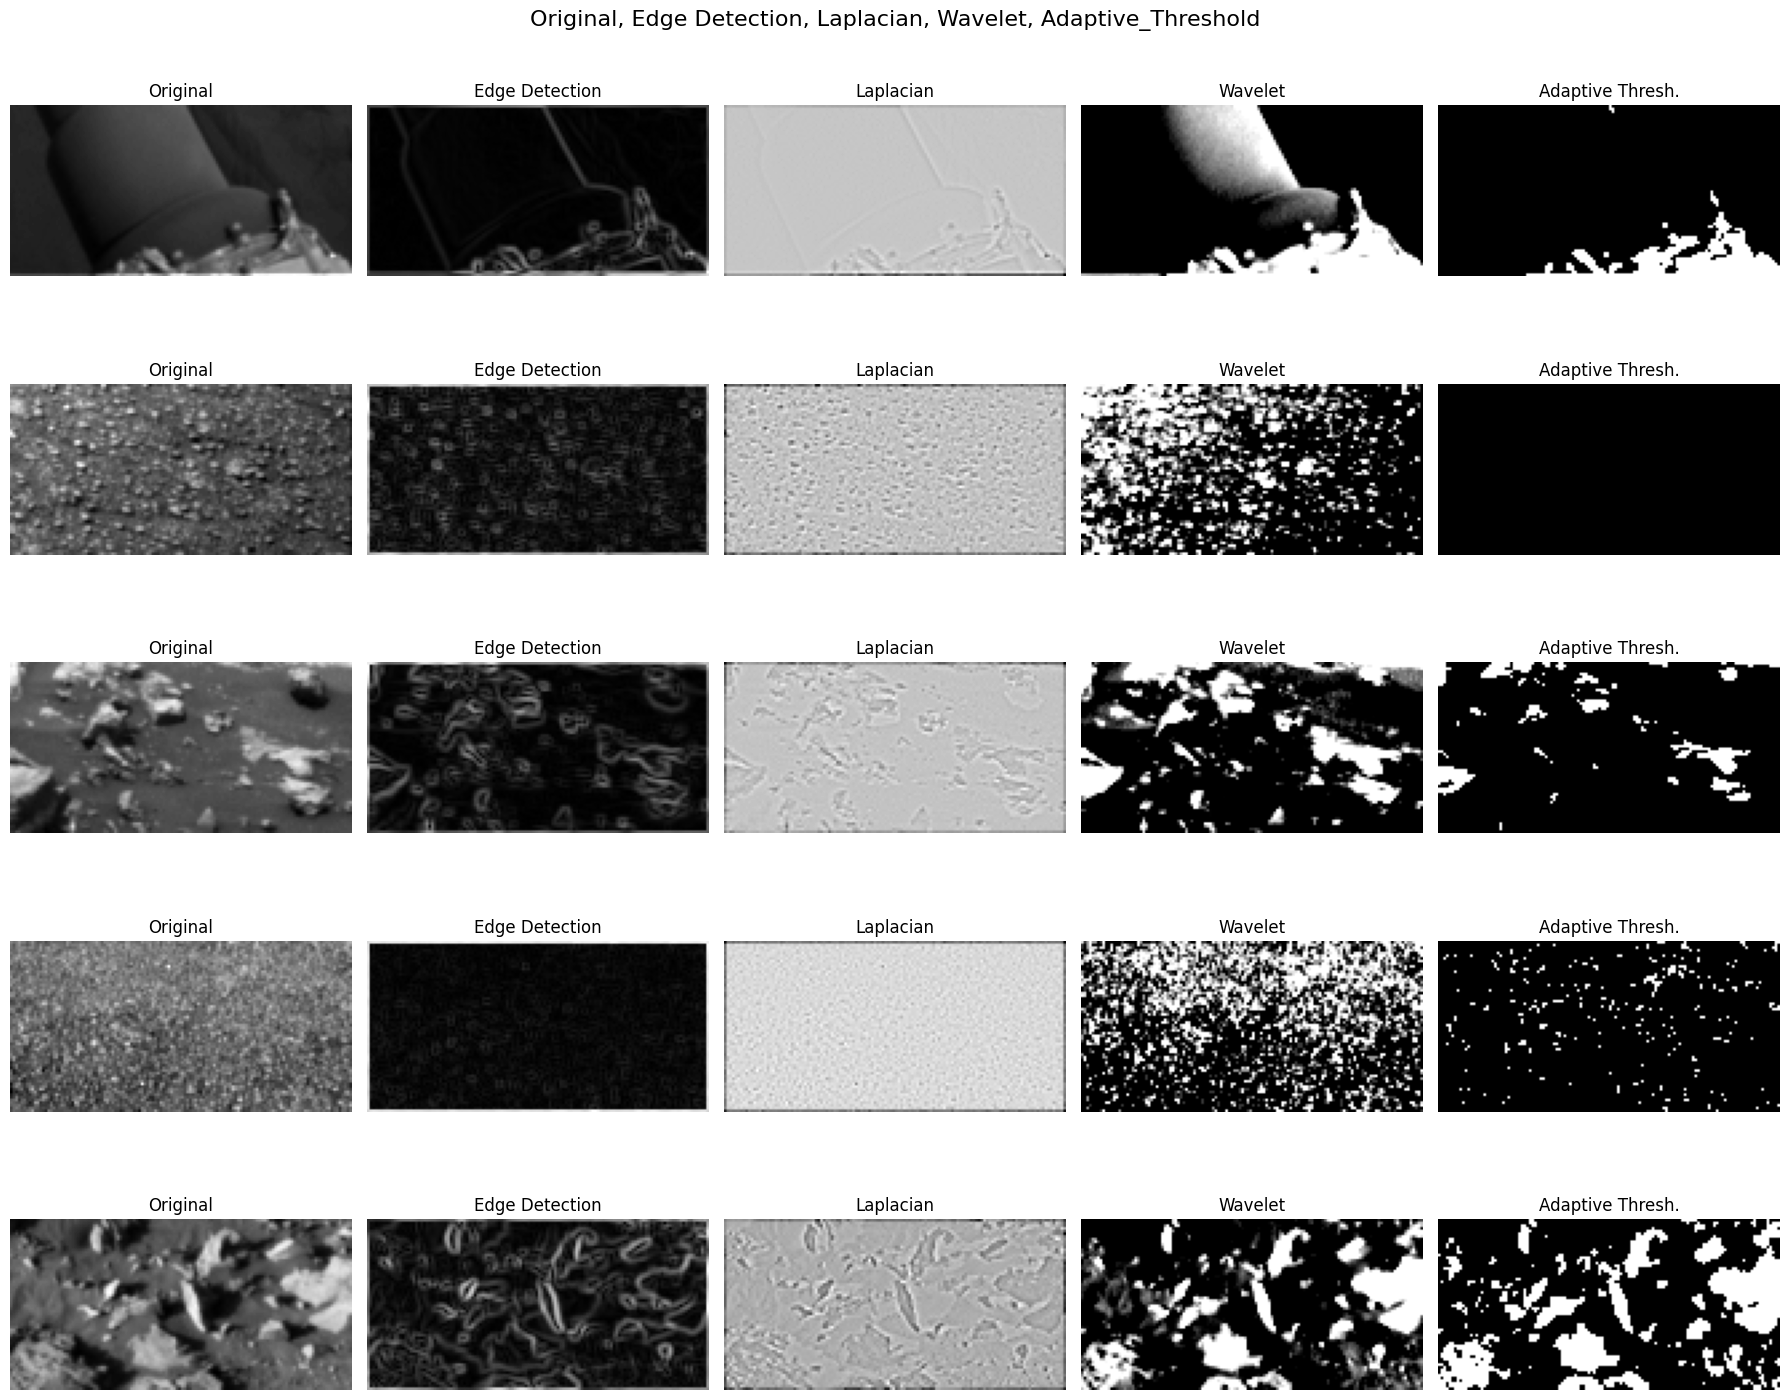

In [ ]:
# Funzione per visualizzare 5 immagini casuali per ciascun layer
def visualize_transformations(X_train, edge_layer, laplacian_layer, wavelet_layer, adaptive_threshold):
    # Seleziona 5 indici casuali
    np.random.seed(seed)  # Imposta il seed
    random_indices = np.random.choice(len(X_train), size=5, replace=False)  # Genera gli indici casuali
    selected_images = X_train[random_indices]

    # Prepara il layout per le immagini
    fig, axes = plt.subplots(5, 5, figsize=(18, 15))  # 6 columns now
    fig.suptitle("Original, Edge Detection, Laplacian, Wavelet, Adaptive_Threshold", fontsize=16)

    for i, img in enumerate(selected_images):
        img = img[np.newaxis, ..., np.newaxis]  # Aggiunge batch e channel dimension

        # Applica i layer custom
        edges = edge_layer(img).numpy().squeeze()
        laplacian = laplacian_layer(img).numpy().squeeze()
        wavelet_transformed = wavelet_layer(img).numpy().squeeze()
        adaptive_threshold_transformed = adaptive_threshold(img).numpy().squeeze()

        # Visualizza immagini
        axes[i, 0].imshow(img.squeeze(), cmap='gray')
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(edges, cmap='gray')
        axes[i, 1].set_title("Edge Detection")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(laplacian, cmap='gray')
        axes[i, 2].set_title("Laplacian")
        axes[i, 2].axis('off')

        axes[i, 3].imshow(wavelet_transformed, cmap='gray')
        axes[i, 3].set_title("Wavelet")
        axes[i, 3].axis('off')

        axes[i, 4].imshow(adaptive_threshold_transformed, cmap='gray')
        axes[i, 4].set_title("Adaptive Thresh.")
        axes[i, 4].axis('off')

    plt.tight_layout()
    plt.show()


# Array di esempio: X_train deve essere già caricato
# Supponiamo che X_train abbia dimensioni (n_samples, 64, 128, 1)
edge_layer = EdgeDetectionLayer(print_flag=True)
laplacian_layer = LaplacianLayer(print_flag=True)
wavelet_layer = WaveletTransformLayer(print_flag=True)
adaptive_threshold = AdaptiveThresholdingLayer(block_size=11, c=0.3,print_flag=True)


# Visualizzazione delle trasformazioni
visualize_transformations(X_train, edge_layer, laplacian_layer, wavelet_layer, adaptive_threshold)


In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [ ]:
# Definizione dei tuoi custom layer, presupponendo che siano già stati implementati:
# AdaptiveThresholdingLayer, EdgeDetectionLayer, LaplacianLayer, Wavelet Layer e unet_block

def get_unet_model(input_shape, num_classes, custom_layers, model_name='UNet'):
    """Defines a single UNet model."""
    inputs = tfkl.Input(shape=input_shape, name=model_name + '_input')

    # Apply custom layers
    threshold_output = custom_layers['AdaptiveThresholdingLayer']()(inputs)
    edge_output = custom_layers['EdgeDetectionLayer']()(inputs)
    laplacian_output = custom_layers['LaplacianLayer']()(inputs)
    wavelet_output = custom_layers['WaveletTransformLayer']()(inputs)

    # Concatenate inputs with outputs from custom layers
    concatenated = tfkl.Concatenate(axis=-1)([inputs, threshold_output, edge_output, laplacian_output, wavelet_output])

    print("Shape of inputs:", inputs.shape)
    print("Shape of threshold_output:", threshold_output.shape)
    print("Shape of edge_output:", edge_output.shape)
    print("Shape of laplacian_output:", laplacian_output.shape)
    print("Shape of wavelet_output:", wavelet_output.shape)
    print("Shape after concatenation:", concatenated.shape)

    # Downsampling path
    down_block_1 = unet_block(concatenated, 32, name=model_name + '_down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name=model_name + '_down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name=model_name + '_bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name=model_name + '_up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name=model_name + '_up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax",
                               name=model_name + '_output_layer')(u2)

    # Build the model
    model = Model(inputs=inputs, outputs=output_layer, name=model_name)
    return model


In [ ]:
def get_dual_unet_model(input_shape=(64, 128, 1), num_classes=5, seed=42):
    """Combines two UNets (global and local) into a dual-UNet architecture."""
    tf.random.set_seed(seed)

    # Define custom layers
    custom_layers = {
        'AdaptiveThresholdingLayer': AdaptiveThresholdingLayer,
        'EdgeDetectionLayer': EdgeDetectionLayer,
        'LaplacianLayer': LaplacianLayer,
        'WaveletTransformLayer': WaveletTransformLayer
    }

    # Input layer
    inputs = tfkl.Input(shape=input_shape, name='dual_unet_input')

    # Global UNet
    global_unet = get_unet_model(input_shape, num_classes, custom_layers, model_name='Global_UNet')
    global_output = global_unet(inputs)

    # Local UNet
    local_unet = get_unet_model(input_shape, num_classes, custom_layers, model_name='Local_UNet')
    local_output = local_unet(inputs)

    # Feature fusion (e.g., concatenation)
    fused_output = tfkl.Concatenate(name='fused_output')([global_output, local_output])

    # Final prediction layer
    final_output = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='final_output')(fused_output)

    # Build the dual-UNet model
    model = Model(inputs=inputs, outputs=final_output, name='Dual_UNet')
    return model

Shape of inputs: (None, 64, 128, 1)
Shape of threshold_output: (None, 64, 128, 1)
Shape of edge_output: (None, 64, 128, 1)
Shape of laplacian_output: (None, 64, 128, 1)
Shape of wavelet_output: (None, 64, 128, 1)
Shape after concatenation: (None, 64, 128, 5)
Shape of inputs: (None, 64, 128, 1)
Shape of threshold_output: (None, 64, 128, 1)
Shape of edge_output: (None, 64, 128, 1)
Shape of laplacian_output: (None, 64, 128, 1)
Shape of wavelet_output: (None, 64, 128, 1)
Shape after concatenation: (None, 64, 128, 5)


Model: "Dual_UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ dual_unet_input        │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ Global_UNet            │ (None, 64, 128, 5)   │      474,821 │ dual_unet_input[0]… │    Y    │
│ (Functional)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ Global_UNet_input │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ adaptive_thresholding… │                      │              │                     │         │
│ (AdaptiveThresholding… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ edge_detection_layer_1 │                      │              │                     │         │
│ (EdgeDetectionLayer)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ laplacian_layer_1 │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (LaplacianLayer)       │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ wavelet_transform_lay… │                      │              │                     │         │
│ (WaveletTransformLaye… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ concatenate       │ (None, 64, 128, 5)   │            0 │ -                   │    -    │
│ (Concatenate)          │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 64, 128, 32)  │        1,472 │ -                   │    Y    │
│ Global_UNet_down_bloc… │                      │              │                     │         │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 64, 128, 32)  │          128 │ -                   │    Y    │
│ Global_UNet_down_bloc… │                      │              │                     │         │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 64, 128, 32)  │            0 │ -                   │    -    │
│ Global_UNet_down_bloc… │                      │              │                     │         │
│ (Activation)           │                      │              │                     │         │
├──────────────────────

 Total params: 949,697 (3.62 MB)

 Trainable params: 947,137 (3.61 MB)

 Non-trainable params: 2,560 (10.00 KB)

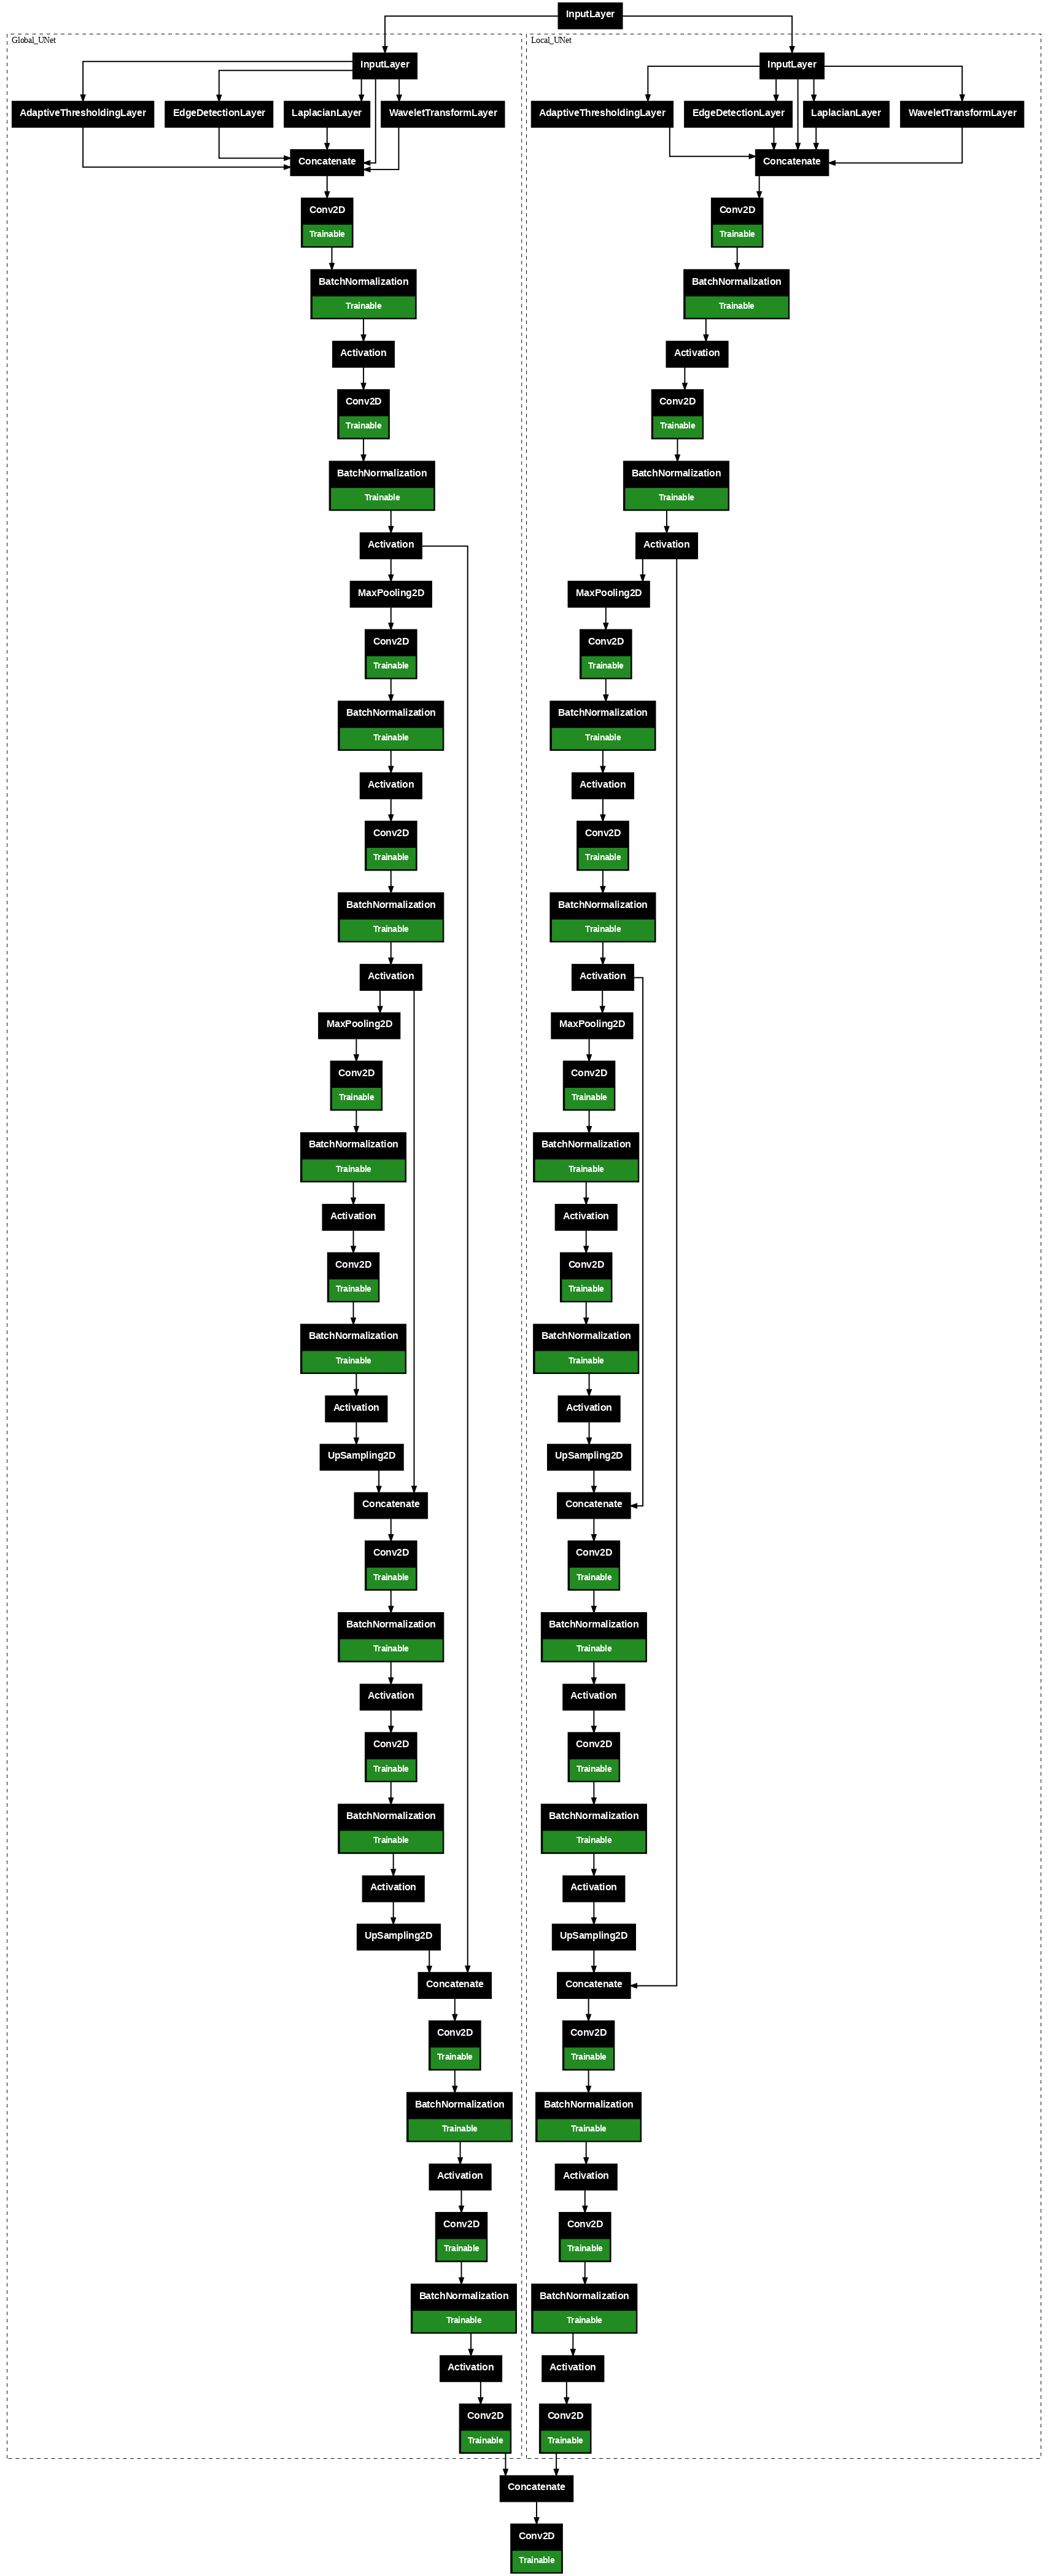

In [ ]:
# Create the dual-UNet model
model = get_dual_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [ ]:
# Define the MeanIoU ignoring the background class
# mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

# Custom Version
import tensorflow as tf

@register_keras_serializable(package="Custom", name="CustomMeanIoU")
class CustomMeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, ignore_class=None, name="mean_iou", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.ignore_class = ignore_class
        self.iou_metric = tf.keras.metrics.MeanIoU(num_classes=num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)  # Convert probabilities to class indices
        y_true = tf.cast(y_true, tf.int32)

        # Ignore the specified class
        if self.ignore_class is not None:
            mask = tf.not_equal(y_true, self.ignore_class)  # Filter out the ignored class
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        self.iou_metric.update_state(y_true, y_pred)

    def result(self):
        return self.iou_metric.result()

    def reset_states(self):
        self.iou_metric.reset_states()

    def get_config(self):
        """Serialize the configuration of the metric."""
        config = super().get_config()
        config.update({
            "num_classes": self.num_classes,
            "ignore_class": self.ignore_class,
        })
        return config

    @classmethod
    def from_config(cls, config):
        """Reconstruct the metric from its config."""
        return cls(**config)


In [ ]:
mean_iou = CustomMeanIoU(num_classes=num_classes, ignore_class=0)

In [ ]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE,clipnorm=1.0),
    metrics=["accuracy", mean_iou]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

In [ ]:
class DebugCallback(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        if logs['loss'] == float('nan'):
            print(f"NaN detected at batch {batch}")
            self.model.stop_training = True

In [ ]:
# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    sample_weight=sample_weights_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val,y_val),
    callbacks=[early_stopping],
    verbose=1
).history


Epoch 1/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.3701 - loss: 1.5325 - mean_iou: 0.1515 - val_accuracy: 0.4211 - val_loss: 1.5209 - val_mean_iou: 0.1913
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 230ms/step - accuracy: 0.3921 - loss: 1.4093 - mean_iou: 0.1773 - val_accuracy: 0.3924 - val_loss: 1.5981 - val_mean_iou: 0.1244
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.4018 - loss: 1.3694 - mean_iou: 0.1810 - val_accuracy: 0.3924 - val_loss: 1.6261 - val_mean_iou: 0.0993
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.4205 - loss: 1.3481 - mean_iou: 0.1952 - val_accuracy: 0.2723 - val_loss: 1.6075 - val_mean_iou: 0.1038
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - accuracy: 0.4928 - loss: 1.2941 - mean_iou: 0.2698 - val_accuracy: 0.1125 - val_loss: 1.7127 - val_mean_iou: 0.0503
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - accuracy: 0.5189 - loss: 1.2695 - mean_iou: 0.2868 - val_accuracy: 0.0036 - val_lo

In [ ]:
print(np.unique(y_train))  # Controlla se ci sono classi mancanti

[0. 1. 2. 3. 4.]


In [ ]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model_'+str(sub_number)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Final validation Mean Intersection Over Union: 54.11%


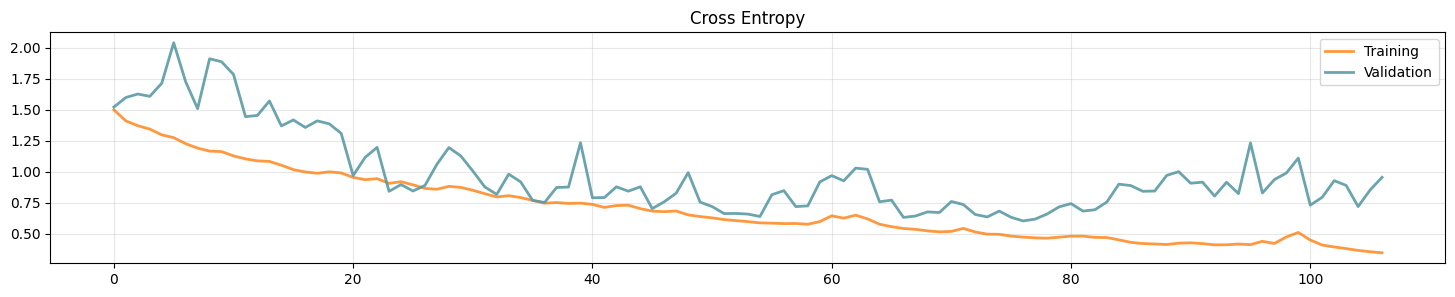

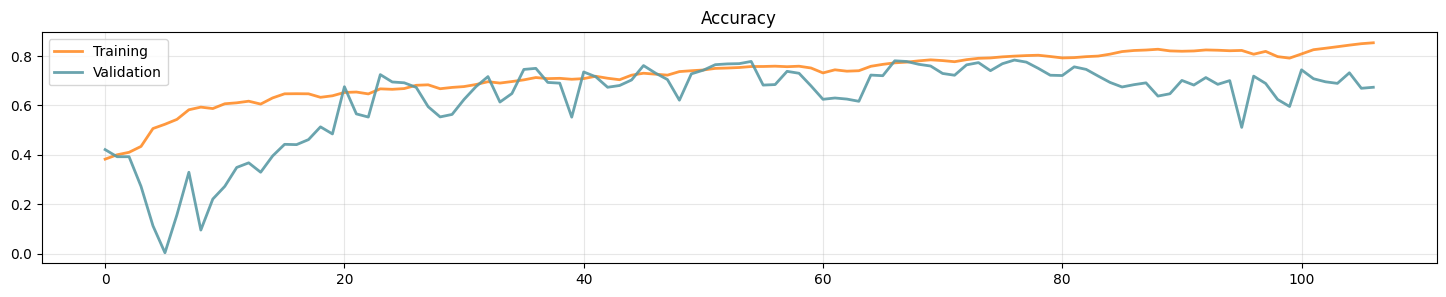

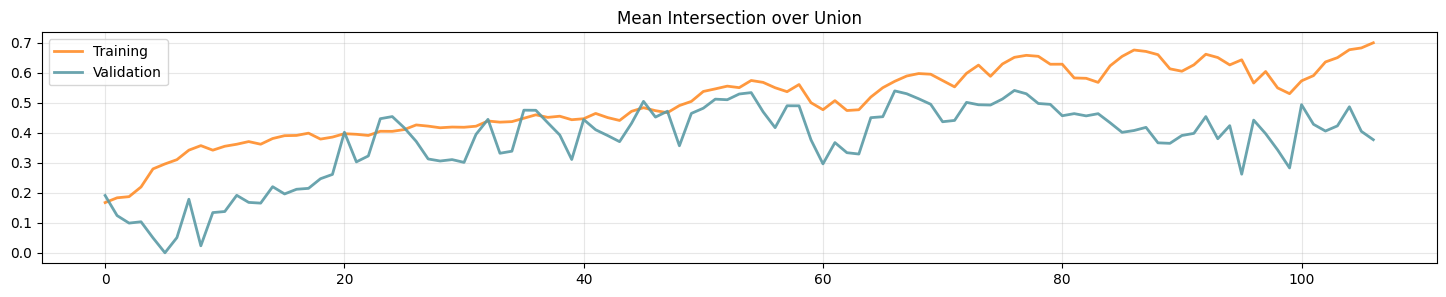

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Load UNet model without compiling
model = tfk.models.load_model('model_'+str(sub_number)+'.keras', compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", mean_iou]
)

In [ ]:
print(model.metrics_names)

['loss', 'compile_metrics']


In [ ]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(
    X_test, y_test, verbose=0, batch_size=10
)
print(f'Test Loss: {round(test_loss, 4)}')
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

Test Loss: 0.721
Test Accuracy: 0.7395
Test Mean Intersection over Union: 0.4286


In [ ]:
model_filename = f"model_after_test_{sub_number}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_after_test_21.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from model_after_test_21.keras


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 174 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
preds = model.predict(X_test_kaggle)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(submission_filename)

submission_after_test_21.csv
